# 99 · Debug de inferencia offline en vuelta grabada

Este notebook:

- Carga un `driving_log.csv` + `IMG` de una vuelta concreta del simulador.
- Aplica el mismo preprocesado y encoder que en entrenamiento.
- Ejecuta el modelo checkpoint (`task_2_circuito2`) frame a frame.
- Calcula métricas de error (MAE en grados, rectas vs curvas) y genera:
  - curva temporal ángulo real vs predicho,
  - scatter predicho vs real,
  - histograma del error absoluto.

Sirve para **analizar el comportamiento del modelo** en una vuelta grabada
sin depender del modo autónomo del simulador.

[CFG] ROOT        = /home/cesar/proyectos/TFM_SNN
[CFG] DATASET_RAW = udacity
[CFG] CIRCUIT_DIR = /home/cesar/proyectos/TFM_SNN/data/raw/udacity/circuito2/vuelta2
[CFG] CKPT        = /home/cesar/proyectos/TFM_SNN/outputs/continual_std_sa-snn_best_sa_k013_vt120_rate_model-PilotNetSNN_66x200_gray_seed_42/task_2_circuito2/best.pth
[CFG] PRESET      = std
[CFG] encoder=rate T=18 gain=0.7
[CFG] img=200x66 to_gray=True | crop_top=60 crop_bottom=20
[OK] Modelo cargado en cuda

[DEBUG] Primeras 5 filas de driving_log con nombres normalizados:


,center,left,right,steering,throttle,brake,speed,img_name,img_path,exists
0,C:\Aplicaciones\circuitos\C2_2\IMG\center_2025...,C:\Aplicaciones\circuitos\C2_2\IMG\left_2025_...,C:\Aplicaciones\circuitos\C2_2\IMG\right_2025...,0.0,0.0,0.0,5.016868,center_2025_08_14_17_53_49_369.jpg,/home/cesar/proyectos/TFM_SNN/data/raw/udacity...,True
1,C:\Aplicaciones\circuitos\C2_2\IMG\center_2025...,C:\Aplicaciones\circuitos\C2_2\IMG\left_2025_...,C:\Aplicaciones\circuitos\C2_2\IMG\right_2025...,0.0,0.0,0.0,5.015257,center_2025_08_14_17_53_49_472.jpg,/home/cesar/proyectos/TFM_SNN/data/raw/udacity...,True
2,C:\Aplicaciones\circuitos\C2_2\IMG\center_2025...,C:\Aplicaciones\circuitos\C2_2\IMG\left_2025_...,C:\Aplicaciones\circuitos\C2_2\IMG\right_2025...,0.0,0.0,0.0,5.006330,center_2025_08_14_17_53_49_574.jpg,/home/cesar/proyectos/TFM_SNN/data/raw/udacity...,True
3,C:\Aplicaciones\circuitos\C2_2\IMG\center_2025...,C:\Aplicaciones\circuitos\C2_2\IMG\left_2025_...,C:\Aplicaciones\circuitos\C2_2\IMG\right_2025...,0.0,0.0,0.0,4.997367,center_2025_08_14_17_53_49_675.jpg,/home/cesar/proyectos/TFM_SNN/data/raw/udacity...,True
4,C:\Aplicaciones\circuitos\C2_2\IMG\center_2025...,C:\Aplicaciones\circuitos\C2_2\IMG\left_2025_...,C:\Aplicaciones\circuitos\C2_2\IMG\right_2025...,0.0,0.0,0.0,4.983463,center_2025_08_14_17_53_49_777.jpg,/home/cesar/proyectos/TFM_SNN/data/raw/udacity...,True


[DEBUG] Ejemplo de img_path calculado: /home/cesar/proyectos/TFM_SNN/data/raw/udacity/circuito2/vuelta2/IMG/center_2025_08_14_17_53_49_369.jpg (exists=True)
[INFO] muestras totales con imagen=1034

[DEBUG] Primera muestra
  img_name: center_2025_08_14_17_53_49_369.jpg
  bgr.shape: (160, 320, 3)
  x_img.shape: (1, 66, 200) | min/max: 0.003921568859368563 0.7019608020782471
  xT.shape: (18, 1, 66, 200)
  x5d.shape: (18, 1, 1, 66, 200)

[INFO] Número de frames evaluados: 1034

[STATS] GLOBAL: n=1034 | MAE_deg=5.08 | max_err_deg=25.00
[STATS] RECTAS (|steer| <= 0.02): n=578 | MAE_deg=5.22 | max_err_deg=25.00
[STATS] CURVAS FUERTES (|steer| >= 0.1): n=385 | MAE_deg=4.71 | max_err_deg=21.44


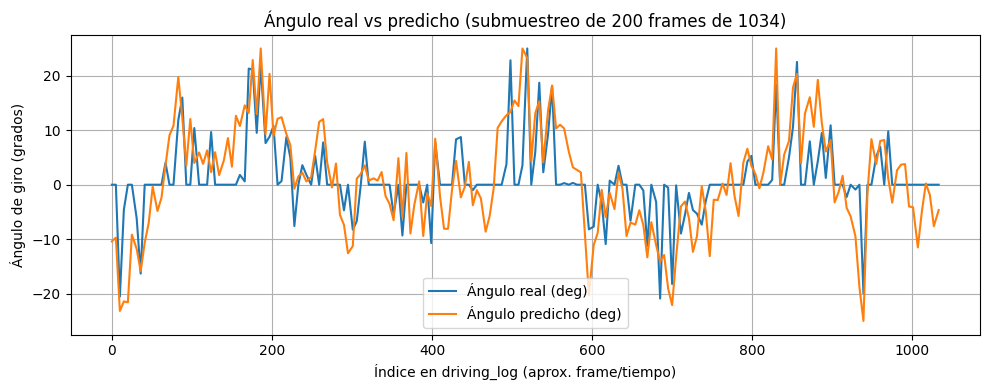

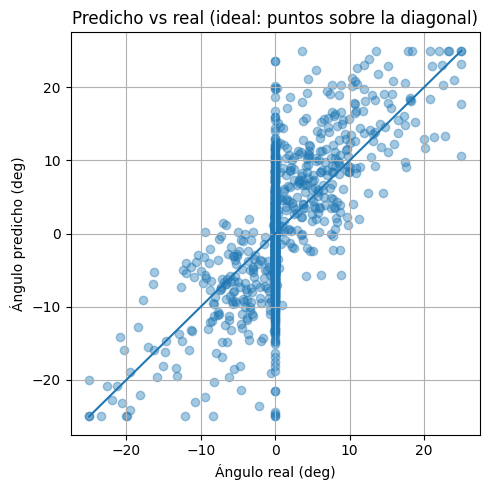

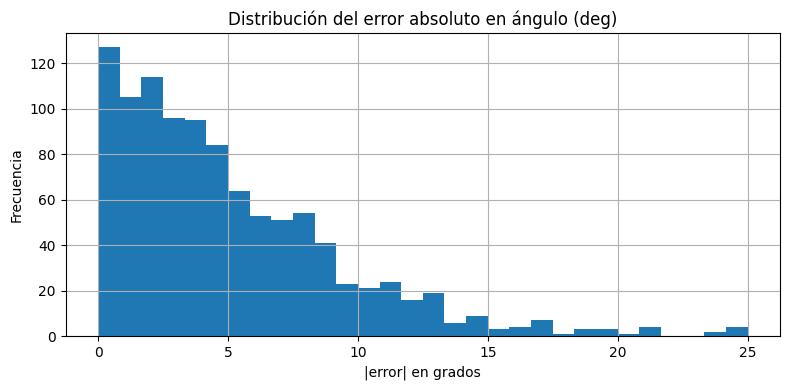


[RESUMEN GLOBAL] MAE (deg): 5.08 | Error máximo (deg): 25.00


In [ ]:
from pathlib import Path
import sys
import numpy as np
import pandas as pd
import torch
from torch.amp import autocast
import cv2
import matplotlib.pyplot as plt
from IPython.display import display

# =========================
# 0) CONFIGURACIÓN BÁSICA
# =========================
ROOT = Path("/home/cesar/proyectos/TFM_SNN").resolve()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

# --- selecciona dataset RAW: udacity (nuevo) vs udacity.crop (viejo) ----
USE_UDACITY_CROP = True   # <- IMPORTANTE:
                           #    False  -> modelos nuevos (recorte en el preset)
                           #    True   -> modelos viejos que usaban udacity.crop

DATASET_RAW = "udacity" if USE_UDACITY_CROP else "udacity.org"

CIRCUITO = 2
VUELTA   = 2

CIRCUIT_DIR = ROOT / "data" / "raw" / DATASET_RAW / f"circuito{CIRCUITO}" / f"vuelta{VUELTA}"
LOG_PATH = CIRCUIT_DIR / "driving_log.csv"
IMG_DIR  = CIRCUIT_DIR / "IMG"

# Checkpoint a probar (task_2_circuito2 del run que quieras)
# CKPT VIEJO (sin recorte en preset / udacity.crop)
# CKPT = ROOT / "outputs" / \
#     "continual_std_as-snn_gr_0.5_lam_0.2_ema_0.9_l1_scale_on_std_as_input_gr050_lam0p20_scaling_on_s07_rate_model-PilotNetSNN_66x200_gray_seed_42" / \
#     "task_2_circuito2" / "best.pth"

# CKPT NUEVO (recorte en preset / usar RAW 'udacity')
CKPT = ROOT / "outputs" / \
    "continual_std_sa-snn_best_sa_k013_vt120_crop_06122025_rate_model-PilotNetSNN_66x200_gray_seed_42" / \
    "task_2_circuito2" / "best.pth"

# Preset con el que se entrenó ese run ("std" / "accurate" / "fast")
PRESET = "std"

# Umbrales y rangos
DEG_RANGE        = 25.0   # labels en [-1,1] → ±25º
STRAIGHT_MAX_ABS = 0.02   # rectas: |steer| <= 0.02 → ±0.5º aprox
CURVE_MIN_ABS    = 0.10   # curvas fuertes: |steer| >= 0.10 → ±2.5º aprox
N_PLOT_MAX       = 200    # nº máximo de puntos en las gráficas de serie temporal

print("[CFG] ROOT        =", ROOT)
print("[CFG] DATASET_RAW =", DATASET_RAW)
print("[CFG] CIRCUIT_DIR =", CIRCUIT_DIR)
print("[CFG] CKPT        =", CKPT)
print("[CFG] PRESET      =", PRESET)


# =========================
# 1) Imports del proyecto
# =========================
from src.config import load_preset
from src.models import build_model
from src.datasets import ImageTransform, encode_rate as enc_rate, encode_latency as enc_latency

# =========================
# 2) Cargar preset + modelo
# =========================
cfg = load_preset(ROOT / "configs" / "presets.yaml", PRESET)
DATA, MODEL = cfg["data"], cfg["model"]

encoder = DATA["encoder"]
T       = int(DATA["T"])
gain    = float(DATA["gain"])
W       = int(MODEL["img_w"])
H       = int(MODEL["img_h"])
to_gray = bool(MODEL["to_gray"])
crop_top = int(MODEL.get("crop_top", 0) or 0)
crop_bottom = int(MODEL.get("crop_bottom", 0) or 0)

print(f"[CFG] encoder={encoder} T={T} gain={gain}")
print(f"[CFG] img={W}x{H} to_gray={to_gray} "
      f"| crop_top={crop_top} crop_bottom={crop_bottom}")

tfm = ImageTransform(
    W, H,
    to_gray=to_gray,
    crop_top=crop_top or None,
    crop_bottom=crop_bottom or None,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = build_model("pilotnet_snn", tfm, beta=0.9, threshold=0.5)

state = torch.load(CKPT, map_location=device)
if isinstance(state, dict) and "state_dict" in state:
    sd = state["state_dict"]
elif isinstance(state, dict) and "model_state_dict" in state:
    sd = state["model_state_dict"]
else:
    sd = state

model.load_state_dict(sd)
model.to(device)
model.eval()
print(f"[OK] Modelo cargado en {device}")

# =========================
# 3) Encoder temporal runtime (mismo que sim_drive)
# =========================
def make_encode_runtimer(encoder: str, T: int, gain: float):
    enc = str(encoder).lower()
    if enc not in {"rate", "latency", "raw", "image"}:
        raise ValueError(f"Encoder no soportado: {encoder}")

    def _fn(x_img: torch.Tensor) -> torch.Tensor:
        # x_img: (C,H,W) float32 [0,1]
        if enc == "image":
            return x_img.unsqueeze(0)               # (1,C,H,W)
        elif enc == "rate":
            return enc_rate(x_img, T=T, gain=gain)  # (T,C,H,W) o (T,H,W)
        elif enc == "latency":
            return enc_latency(x_img, T=T)          # (T,C,H,W) o (T,H,W)
        elif enc == "raw":
            if x_img.dim() == 2:
                x_img = x_img.unsqueeze(0)
            return x_img.unsqueeze(0).expand(T, *x_img.shape).contiguous()

    return _fn

encode_runtime = make_encode_runtimer(encoder, T, gain)

# =========================
# 4) Cargar driving_log y normalizar rutas
# =========================
if not LOG_PATH.exists():
    raise FileNotFoundError(f"No existe driving_log: {LOG_PATH}")
if not IMG_DIR.exists():
    raise FileNotFoundError(f"No existe carpeta IMG: {IMG_DIR}")

log = pd.read_csv(LOG_PATH, header=None)
log.columns = ["center", "left", "right", "steering", "throttle", "brake", "speed"]

def _basename_any(p) -> str:
    s = str(p).strip()
    s = s.replace("\\", "/")
    return s.split("/")[-1]

log["img_name"] = log["center"].apply(_basename_any)
log["img_path"] = log["img_name"].apply(lambda n: IMG_DIR / n)
log["exists"]   = log["img_path"].apply(lambda p: p.exists())

print("\n[DEBUG] Primeras 5 filas de driving_log con nombres normalizados:")
display(log.head())
print(f"[DEBUG] Ejemplo de img_path calculado: {log.iloc[0]['img_path']} (exists={log.iloc[0]['exists']})")

# Nos quedamos solo con las filas que realmente tienen imagen en disco
log = log[log["exists"]].copy()
log = log.reset_index(drop=False)    # guardamos índice original en col 'index'
log["abs_steer"] = log["steering"].astype(float).abs()

print(f"[INFO] muestras totales con imagen={len(log)}")

# =========================
# 5) Inferencia frame a frame sobre TODA la vuelta
# =========================
DEBUG_FIRST = {"done": False}
results = []

for _, row in log.iterrows():
    img_path = row["img_path"]
    bgr = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
    if bgr is None:
        # Por si acaso, aunque en principio no debería ocurrir
        continue

    # 1) Transform (igual que en entrenamiento)
    x_img = tfm(bgr).float()          # (C,H,W) en [0,1]

    # 2) Encode temporal (igual que en sim_drive)
    xT = encode_runtime(x_img)        # (T,C,H,W) o (T,H,W)
    if xT.dim() == 3:
        xT = xT.unsqueeze(1)          # (T,H,W) -> (T,1,H,W)
    if xT.dim() == 4:
        x5d = xT.unsqueeze(1)         # (T,C,H,W) -> (T,1,C,H,W)
    else:
        x5d = xT                      # asumimos ya 5D

    # Debug detallado solo para la primera muestra
    if not DEBUG_FIRST["done"]:
        print("\n[DEBUG] Primera muestra")
        print("  img_name:", img_path.name)
        print("  bgr.shape:", bgr.shape)
        print("  x_img.shape:", tuple(x_img.shape),
              "| min/max:", float(x_img.min().item()), float(x_img.max().item()))
        print("  xT.shape:", tuple(xT.shape))
        print("  x5d.shape:", tuple(x5d.shape))
        DEBUG_FIRST["done"] = True

    # 3) Inferencia
    with torch.no_grad():
        x5d_dev = x5d.to(device, non_blocking=True)
        use_amp = torch.cuda.is_available()
        with autocast("cuda", enabled=use_amp):
            y = model(x5d_dev)
        steer_pred = float(y.squeeze().detach().cpu().item())
        steer_pred = float(np.clip(steer_pred, -1.0, 1.0))

    steer_gt = float(row["steering"])
    speed_gt = float(row["speed"])

    steer_gt_deg   = steer_gt * DEG_RANGE
    steer_pred_deg = steer_pred * DEG_RANGE
    err_deg        = steer_pred_deg - steer_gt_deg

    results.append({
        "log_index": int(row["index"]),   # índice original en driving_log
        "img_name": img_path.name,
        "steer_gt_norm": steer_gt,
        "steer_pred_norm": steer_pred,
        "steer_gt_deg": steer_gt_deg,
        "steer_pred_deg": steer_pred_deg,
        "err_deg": err_deg,
        "speed": speed_gt,
    })

df_all = pd.DataFrame(results)
if df_all.empty:
    raise RuntimeError("[ERROR] df_all vacío; algo ha fallado en la inferencia.")

df_all = df_all.sort_values("log_index").reset_index(drop=True)
df_all["abs_err_deg"] = df_all["err_deg"].abs()

print("\n[INFO] Número de frames evaluados:", len(df_all))

# =========================
# 6) Métricas agregadas (global / rectas / curvas fuertes)
# =========================
# Necesitamos el steering GT otra vez (lo tomamos del log alineado por log_index)
log_steer = log.set_index("index")["steering"].astype(float)
df_all["steer_gt_norm"] = df_all["log_index"].map(log_steer)
df_all["abs_steer_gt"]  = df_all["steer_gt_norm"].abs()

mask_rectas = df_all["abs_steer_gt"] <= STRAIGHT_MAX_ABS
mask_curvas = df_all["abs_steer_gt"] >= CURVE_MIN_ABS

def print_stats(label, mask):
    sub = df_all[mask] if mask is not None else df_all
    if sub.empty:
        print(f"[STATS] {label}: sin muestras")
        return
    mae = sub["abs_err_deg"].mean()
    maxe = sub["abs_err_deg"].max()
    print(f"[STATS] {label}: n={len(sub)} | MAE_deg={mae:.2f} | max_err_deg={maxe:.2f}")

print()
print_stats("GLOBAL", None)
print_stats(f"RECTAS (|steer| <= {STRAIGHT_MAX_ABS})", mask_rectas)
print_stats(f"CURVAS FUERTES (|steer| >= {CURVE_MIN_ABS})", mask_curvas)

# =========================
# 7) Gráficas (submuestreamos para que se vean claras)
# =========================
# Submuestreo uniforme para la gráfica temporal
n_total = len(df_all)
n_plot  = min(n_total, N_PLOT_MAX)
idx_plot = np.linspace(0, n_total - 1, num=n_plot, dtype=int)
df_plot = df_all.iloc[idx_plot].reset_index(drop=True)

df_plot["t"] = df_plot["log_index"]   # eje x: índice original (aprox. tiempo)

# ---- 1) Curva temporal real vs predicho ----
plt.figure(figsize=(10, 4))
plt.plot(df_plot["t"], df_plot["steer_gt_deg"], label="Ángulo real (deg)")
plt.plot(df_plot["t"], df_plot["steer_pred_deg"], label="Ángulo predicho (deg)")
plt.xlabel("Índice en driving_log (aprox. frame/tiempo)")
plt.ylabel("Ángulo de giro (grados)")
plt.title(f"Ángulo real vs predicho (submuestreo de {n_plot} frames de {n_total})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---- 2) Scatter predicho vs real (usamos TODOS los frames) ----
plt.figure(figsize=(5, 5))
plt.scatter(df_all["steer_gt_deg"], df_all["steer_pred_deg"], alpha=0.4)
mn = min(df_all["steer_gt_deg"].min(), df_all["steer_pred_deg"].min())
mx = max(df_all["steer_gt_deg"].max(), df_all["steer_pred_deg"].max())
plt.plot([mn, mx], [mn, mx])  # y = x
plt.xlabel("Ángulo real (deg)")
plt.ylabel("Ángulo predicho (deg)")
plt.title("Predicho vs real (ideal: puntos sobre la diagonal)")
plt.grid(True)
plt.tight_layout()
plt.show()

# ---- 3) Histograma del error absoluto (todos los frames) ----
plt.figure(figsize=(8, 4))
plt.hist(df_all["abs_err_deg"], bins=30)
plt.xlabel("|error| en grados")
plt.ylabel("Frecuencia")
plt.title("Distribución del error absoluto en ángulo (deg)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Resumen numérico global (para acompañar las figuras)
mae_total = df_all["abs_err_deg"].mean()
max_err   = df_all["abs_err_deg"].max()
print(f"\n[RESUMEN GLOBAL] MAE (deg): {mae_total:.2f} | Error máximo (deg): {max_err:.2f}")
